In [90]:
from tsai.models import MINIROCKET, HydraMultiRocketPlus, TST, MINIROCKET_Pytorch
from tsai.learner import ts_learner
from data_loader import DataLoader_HRI
from tsai.data.all import *
from tsai.models.utils import *
from tsai.all import my_setup, ShowGraphCallback2, LabelSmoothingCrossEntropyFlat, RocAucBinary, accuracy, ShowGraph
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna
from optuna.integration import WeightsAndBiasesCallback
import wandb
import json
import datetime
import platform
import pandas as pd 
import numpy as np
from get_metrics import get_metrics
import matplotlib.pyplot as plt


<ErrorbarContainer object of 3 artists>

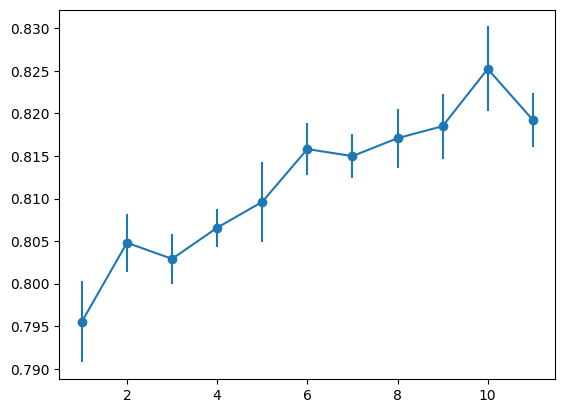

In [92]:
scores= [[0.8217285824887209, 0.8223741781894571, 0.8210829867879849, 0.8169748797704101, 0.8140142182365654], [0.8210577682059248, 0.8246438505748576, 0.8290470150025344, 0.8324616110134592, 0.8189394073128844], [0.8176885656427082, 0.8185485192909544, 0.8153180189290677, 0.8257030310213778, 0.8152247101754456], [0.812276657932631, 0.8155853358989037, 0.8179634481871623, 0.8229138558455412, 0.816715128375192], [0.8125792809173511, 0.8143496253779635, 0.8146169423477996, 0.8133534913865933, 0.8200187626250527], [0.811424269859003, 0.816959748621174, 0.8179256203140722, 0.8196682243344185, 0.8130836525585512], [0.806541952372186, 0.8141831827363675, 0.806499080782684, 0.8045875122625356, 0.8162460627488759], [0.8031374437940852, 0.8093765209957305, 0.8074649524755821, 0.8050389248814096, 0.8078356656318642], [0.7986712329112583, 0.8002953095959227, 0.8047690860533676, 0.8042874111360214, 0.8065369086557739], [0.7989612466049484, 0.8029936978763432, 0.80714467648342, 0.8079415836765163, 0.806978233841824], [0.8024590639366711, 0.791804213016319, 0.8002246975661547, 0.7912115763379088, 0.7919857868071509]]
# plot the scores
scores = scores [::-1]
# linechart with standard deviation
plt.errorbar([i for i in range(1, len(scores)+1)], np.mean(scores, axis=1), yerr=np.std(scores, axis=1), fmt='-o')


In [2]:
data_hri = DataLoader_HRI("../data/", verbose=True)

['0_val.csv', '0_train.csv', '1_val.csv', '1_train.csv', '2_val.csv', '2_train.csv', '3_train.csv', '3_val.csv', '4_train.csv', '4_val.csv', '5_train.csv', '5_val.csv', '6_val.csv', '6_train.csv', '7_train.csv', '7_val.csv', '8_train.csv', '8_val.csv', '9_val.csv', '9_train.csv', '10_val.csv', '10_train.csv', '11_train.csv', '11_val.csv', '12_val.csv', '12_train.csv', '13_val.csv', '13_train.csv', '14_train.csv', '14_val.csv', '15_train.csv', '15_val.csv', '16_train.csv', '17_train.csv', '18_train.csv', '19_train.csv', '20_train.csv', '21_train.csv', '22_train.csv', '23_train.csv', '24_train.csv', '25_train.csv', '26_train.csv', '27_train.csv', '28_train.csv', '29_train.csv', '30_train.csv', '31_train.csv', '32_train.csv', '33_train.csv', '34_train.csv', '35_train.csv', '36_train.csv', '37_train.csv', '38_train.csv', '39_train.csv', '40_train.csv', '41_train.csv', '42_train.csv', '43_train.csv', '44_train.csv', '45_train.csv', '46_train.csv', '47_train.csv', '48_train.csv', '49_train.c

In [3]:
data_hri.train_X.head(2)

,frame,robot_speaker,session,participant_speaker,pause_speaker,Loudness_sma3_opensmile,alphaRatio_sma3_opensmile,hammarbergIndex_sma3_opensmile,slope0-500_sma3_opensmile,slope500-1500_sma3_opensmile,...,dist_7_1_openpose,vel_dist_7_1_openpose,dist_7_17_openpose,vel_dist_7_17_openpose,dist_7_15_openpose,vel_dist_7_15_openpose,dist_7_18_openpose,vel_dist_7_18_openpose,dist_7_16_openpose,vel_dist_7_16_openpose
0,1,0.0,0,0.0,1.0,0.332875,6.958805,2.783466,0.053686,0.024778,...,350.298793,0.021715,570.521246,-0.011275,569.255658,-0.575774,519.133681,0.00268,544.621245,0.006379
1,1,0.0,0,0.0,1.0,0.410342,8.734153,3.598458,0.061628,0.029803,...,350.298793,0.021715,570.521246,-0.011275,569.255658,-0.575774,519.133681,0.00268,544.621245,0.006379


In [4]:
val_X_TS_list, val_Y_TS_list, train_X_TS, train_Y_TS, _ = data_hri.get_timeseries_format(
        intervallength=1000, stride_train=1000, fps=100, stride_eval=1000, verbose=True)

TS Processing for session:  0
TS Processing for session:  1
TS Processing for session:  2
TS Processing for session:  3
TS Processing for session:  4
TS Processing for session:  5
TS Processing for session:  6
TS Processing for session:  7
TS Processing for session:  8
TS Processing for session:  9
TS Processing for session:  10
TS Processing for session:  11
TS Processing for session:  12
TS Processing for session:  13
TS Processing for session:  14
TS Processing for session:  15
TS Processing for session:  16
TS Processing for session:  17
TS Processing for session:  18
TS Processing for session:  19
TS Processing for session:  20
TS Processing for session:  21
TS Processing for session:  22
TS Processing for session:  23
TS Processing for session:  24
TS Processing for session:  25
TS Processing for session:  26
TS Processing for session:  27
TS Processing for session:  28
TS Processing for session:  29
TS Processing for session:  30
TS Processing for session:  31
TS Processing for 

In [81]:
# get timeseries format
val_X_TS_list, val_Y_TS_list, train_X_TS, train_Y_TS, _ = data_hri.get_timeseries_format(
    intervallength=1000, stride_train=1000, stride_eval=1000, verbose=False, fps=100, label_creation="full")

train_Y_TS_task = train_Y_TS[:, 2]

In [79]:
train_X_TS.shape
print(np.isnan(train_X_TS).sum())
# print example nan
for i in range(len(train_X_TS)):
    for j in range(len(train_X_TS[i])):
        if np.isnan(train_X_TS[i, j, :]).any():
            print(train_X_TS[i, j, :])
            print(i,j)
            break
def impute_nan_with_feature_mean(data):
    for i in range(data.shape[0]):  # Iterate over each sample
        for j in range(data.shape[1]):  # Iterate over each feature
            feature_values = data[i, j, :]
            nan_mask = np.isnan(feature_values)
            if nan_mask.any():
                feature_mean = np.nanmean(feature_values)
                feature_values[nan_mask] = feature_mean
    return data

train_X_TS = impute_nan_with_feature_mean(train_X_TS)
print(np.isnan(train_X_TS).sum())
print(train_X_TS[120, 64, :])

7710
[194.39437683 194.60049238 194.60049238 194.60049238 194.44900835
 194.44900835 194.44900835 194.50719028 194.50719028 194.50719028
 194.50719028 197.28300025 197.28300025 197.28300025 197.30400009
 197.30400009 197.30400009 197.27400006 197.27400006 197.27400006
 197.27400006 194.42545039 194.42545039 194.42545039 194.38808311
 194.38808311 194.38808311 194.31030359 194.31030359 194.31030359
 194.31030359 194.31965574 194.31965574 194.31965574 194.31990094
 194.31990094 194.31990094 191.5192612  191.5192612  191.5192612
 191.5192612  191.49337109 191.49337109 191.49337109 191.48825473
 191.48825473 191.48825473 191.43100013 191.43100013 191.43100013
 191.43100013 191.39300085 191.39300085 191.39300085 191.42100679
 191.42100679 191.42100679 191.44500075 191.44500075 191.44500075
 191.44500075 191.44460674 191.44460674 191.44460674 191.41936918
 191.41936918 191.41936918 191.4090107  191.4090107  191.4090107
 191.4090107  191.3972144  191.3972144  191.3972144  191.33045138
 191.33

In [82]:
all_X = train_X_TS
for val_X_TS in val_X_TS_list:
    print(val_X_TS.shape, all_X.shape)
    all_X = np.concatenate((all_X, val_X_TS), axis=0)
all_Y = train_Y_TS_task
for val_Y_TS in val_Y_TS_list:
    val_Y_TS = val_Y_TS[:, 2]
    all_Y = np.concatenate((all_Y, val_Y_TS), axis=0)
print(all_X.shape, all_Y.shape)
splits = [range(0, len(train_X_TS)), range(
    len(train_X_TS), len(all_X))]

(47, 94, 1000) (2509, 94, 1000)
(74, 94, 1000) (2556, 94, 1000)
(51, 94, 1000) (2630, 94, 1000)
(37, 94, 1000) (2681, 94, 1000)
(56, 94, 1000) (2718, 94, 1000)
(64, 94, 1000) (2774, 94, 1000)
(31, 94, 1000) (2838, 94, 1000)
(39, 94, 1000) (2869, 94, 1000)
(52, 94, 1000) (2908, 94, 1000)
(63, 94, 1000) (2960, 94, 1000)
(36, 94, 1000) (3023, 94, 1000)
(33, 94, 1000) (3059, 94, 1000)
(50, 94, 1000) (3092, 94, 1000)
(62, 94, 1000) (3142, 94, 1000)
(49, 94, 1000) (3204, 94, 1000)
(43, 94, 1000) (3253, 94, 1000)
(3296, 94, 1000) (3296,)


In [31]:
# how many nans are in all_X
print(np.isnan(all_X).sum())

7710


In [20]:
from tsai.models.utils import *

In [11]:
print(all_X.shape, all_Y.shape)
print(splits)

(3296, 94, 1000) (3296,)
[range(0, 2509), range(2509, 3296)]


MR Torch

SuggestedLRs(valley=8.31763736641733e-06)

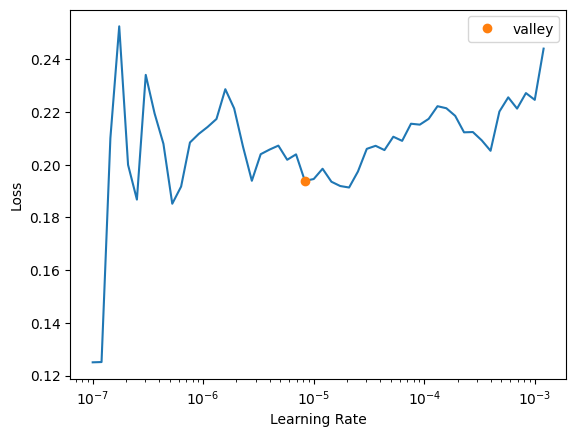

In [36]:
#all_X = np.nan_to_num(all_X, nan=0)
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
#dls = get_ts_dls(all_X, all_Y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dsets = TSDatasets(all_X, all_Y, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, bs=8)
model = build_ts_model(MINIROCKET_Pytorch.MiniRocket, dls=dls) #HydraMultiRocketPlus
learn = ts_learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.lr_find()

In [37]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dsets = TSDatasets(all_X, all_Y, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, bs=8)
model = build_ts_model(MINIROCKET_Pytorch.MiniRocket, dls=dls)
model

MiniRocket(
  (backbone): MiniRocketFeatures()
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(9996, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=9996, out_features=1, bias=True)
  )
)

epoch,train_loss,valid_loss,accuracy,time
0,0.205895,0.214259,0.764930,06:09
1,0.217986,0.223173,0.764930,05:59
2,0.183282,0.210673,0.764930,05:53
3,0.178823,0.193726,0.764930,05:53
4,0.151242,0.190385,0.764930,05:51
5,0.143581,0.180210,0.764930,05:53
6,0.138613,0.182386,0.764930,05:54


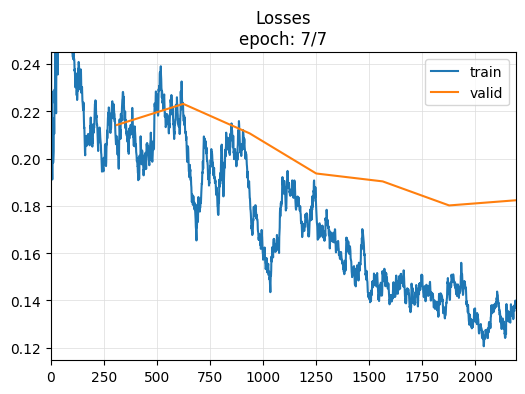

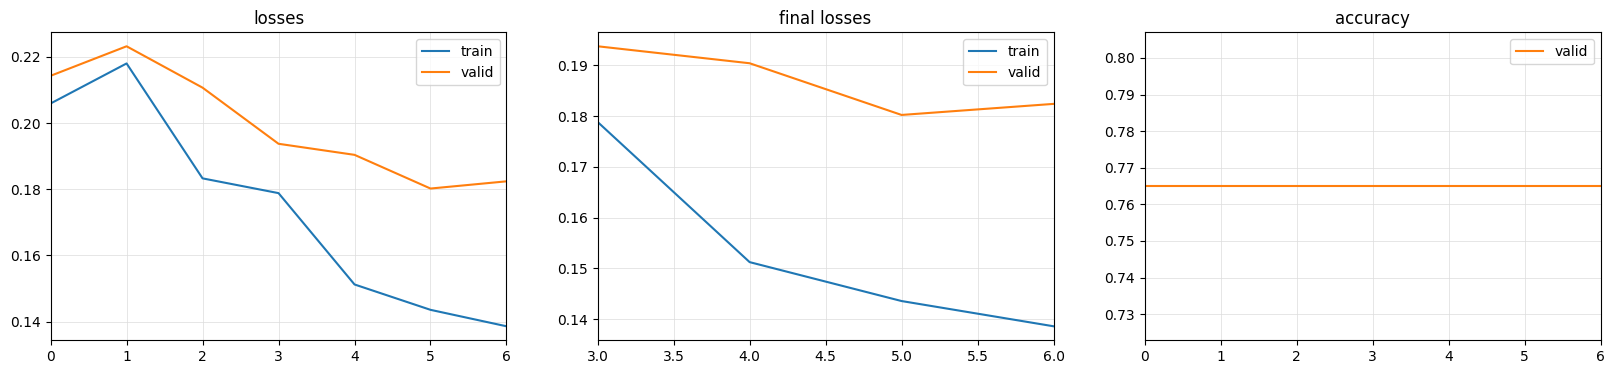

In [83]:
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(all_X, all_Y, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=batch_tfms, bs=8)
model = build_ts_model(MINIROCKET_Pytorch.MiniRocket, dls=dls)
learn = ts_learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(7, 3e-5) # tried: 7e-5, 7e-4, 8e-6, 7e-3


TST

SuggestedLRs(valley=6.309573450380412e-07)

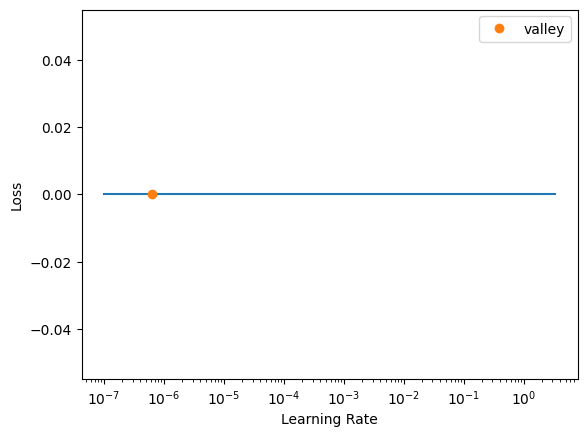

In [7]:
# change nan values in the data 
#all_X = np.nan_to_num(all_X, nan=0)
dsets = TSDatasets(all_X, all_Y, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=4, batch_tfms=TSStandardize(by_var=True))
model = TST.TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.9)
learn = ts_learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(),
                    metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()
#learn.fit_one_cycle(100, 1e-4)

## Whats up with NaNs?

In [6]:
tr = data_hri.train_X
lenght = len(tr)
failed_cols=""
print(len(tr))
for col in tr.columns:
    if tr[col].isna().sum() == lenght:
        print(f"{col}: {tr[col].isna().sum()}!!!!!!")
        failed_cols += "'"+col+"',"
    else:
        print(f"{col}: {tr[col].isna().sum()}")
print(failed_cols)

2537516
frame: 0
robot_speaker: 51
session: 0
participant_speaker: 51
pause_speaker: 51
Loudness_sma3_opensmile: 51
alphaRatio_sma3_opensmile: 51
hammarbergIndex_sma3_opensmile: 51
slope0-500_sma3_opensmile: 51
slope500-1500_sma3_opensmile: 51
spectralFlux_sma3_opensmile: 51
mfcc1_sma3_opensmile: 51
mfcc2_sma3_opensmile: 51
mfcc3_sma3_opensmile: 51
mfcc4_sma3_opensmile: 51
F0semitoneFrom27.5Hz_sma3nz_opensmile: 51
jitterLocal_sma3nz_opensmile: 51
shimmerLocaldB_sma3nz_opensmile: 51
HNRdBACF_sma3nz_opensmile: 51
logRelF0-H1-H2_sma3nz_opensmile: 51
logRelF0-H1-A3_sma3nz_opensmile: 51
F1frequency_sma3nz_opensmile: 51
F1bandwidth_sma3nz_opensmile: 51
F1amplitudeLogRelF0_sma3nz_opensmile: 51
F2frequency_sma3nz_opensmile: 51
F2bandwidth_sma3nz_opensmile: 51
F2amplitudeLogRelF0_sma3nz_opensmile: 51
F3frequency_sma3nz_opensmile: 51
F3bandwidth_sma3nz_opensmile: 51
F3amplitudeLogRelF0_sma3nz_opensmile: 51
AU01_r_openface: 1327
AU01_c_openface: 1327
AU02_r_openface: 1327
AU04_r_openface: 1327
AU

In [13]:
print(tr[tr["session"]==27]["AU26_c_openface"].isna())
# print all the rows where its nan
tr[tr["session"]==27][tr[tr["session"]==27]["AU26_c_openface"].isna()]

0        False
1        False
2        False
3        False
4        False
         ...  
30592     True
30593     True
30594     True
30595     True
30596     True
Name: AU26_c_openface, Length: 30597, dtype: bool


,frame,robot_speaker,session,participant_speaker,pause_speaker,Loudness_sma3_opensmile,alphaRatio_sma3_opensmile,hammarbergIndex_sma3_opensmile,slope0-500_sma3_opensmile,slope500-1500_sma3_opensmile,...,dist_7_1_openpose,vel_dist_7_1_openpose,dist_7_17_openpose,vel_dist_7_17_openpose,dist_7_15_openpose,vel_dist_7_15_openpose,dist_7_18_openpose,vel_dist_7_18_openpose,dist_7_16_openpose,vel_dist_7_16_openpose
30434,9131,1.0,27,0.0,0.0,0.577294,-19.197573,28.708963,-0.045904,-0.031678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30435,9131,1.0,27,0.0,0.0,0.555585,-18.601730,28.219652,-0.045125,-0.030240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30436,9131,1.0,27,0.0,0.0,0.513070,-18.733986,28.214798,-0.052463,-0.025759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30437,9132,1.0,27,0.0,0.0,0.467407,-18.882013,29.299852,-0.062651,-0.026687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30438,9132,1.0,27,0.0,0.0,0.416614,-20.160990,30.184599,-0.065851,-0.030203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30592,9178,0.0,27,0.0,1.0,0.156073,-33.068954,51.045580,-0.091529,-0.024073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30593,9178,0.0,27,0.0,1.0,0.152084,-33.962475,51.646526,-0.091605,-0.024944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30594,9179,0.0,27,0.0,1.0,0.149331,-34.451954,51.806470,-0.091605,-0.026626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30595,9179,0.0,27,0.0,1.0,0.148460,-33.617615,51.893574,-0.077056,-0.019144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# why do the rest of the openpose columns have so many NaNs?
for session in (tr["session"].unique()):
    print(f"Session {session}")
    print(tr[tr["session"]==session]["AU26_c_openface"].isna().sum())


Session 0
0
Session 1
0
Session 2
0
Session 3
0
Session 4
0
Session 5
0
Session 6
0
Session 7
0
Session 8
0
Session 9
0
Session 10
68
Session 11
63
Session 12
63
Session 13
161
Session 14
1
Session 15
0
Session 16
0
Session 17
0
Session 18
0
Session 19
0
Session 20
0
Session 21
0
Session 22
0
Session 23
0
Session 24
60
Session 25
62
Session 26
61
Session 27
163
Session 28
0
Session 29
0
Session 30
0
Session 31
3
Session 32
3
Session 33
0
Session 34
0
Session 35
0
Session 36
0
Session 37
0
Session 38
69
Session 39
59
Session 40
65
Session 41
167
Session 42
0
Session 43
0
Session 44
0
Session 45
0
Session 46
0
Session 47
0
Session 48
0
Session 49
0
Session 50
0
Session 51
60
Session 52
145
Session 53
54
Session 54
0


In [ ]:
# print lenght of each each session in the dataset (per dataframe)

train_Y_counts = data_hri.train_Y["session"].value_counts().sort_index()
train_X_counts = data_hri.train_X["session"].value_counts().sort_index()
val_Y_counts = data_hri.val_Y["session"].value_counts().sort_index()
val_X_counts = data_hri.val_X["session"].value_counts().sort_index()

# print side by side
print("Train")
print(pd.concat([train_Y_counts, train_X_counts], axis=1))
print("Val")
print(pd.concat([val_Y_counts, val_X_counts], axis=1))


Train
         count  count
session              
0        46109  46103
1        51709  51702
2        83206  83200
3        50708  50700
4        54205  54199
5        50909  50902
6        40605  40599
7        52317  52303
8        74100  74102
9        52600  52604
10       32000  31132
11       38300  37708
12       36600  36344
13       40700  40487
14       35613  35605
15       43011  43004
16       48305  48298
17       38411  38402
18       50806  50800
19       37609  37602
20       29911  29903
21       39108  39101
22       51709  51702
23       40300  40298
24       38300  37670
25       41600  40992
26       36400  35650
27       30600  30278
28       53800  53807
29       34200  34199
30       51108  51102
31       37014  37007
32       46614  46607
33       56611  56604
34       33105  33098
35       39811  39804
36       64700  64706
37       41700  41704
38       31500  30836
39       43400  43098
40       35800  35227
41       34700  34188
42       40500  40502
43  

In [6]:
print(data_hri.val_Y["InteractionRupture"].value_counts(normalize=True))
print(data_hri.val_Y["RobotMistake"].value_counts(normalize=True))
print(data_hri.val_Y["UserAwkwardness"].value_counts(normalize=True))

InteractionRupture
0    0.762573
1    0.237427
Name: proportion, dtype: float64
RobotMistake
0    0.854997
1    0.145003
Name: proportion, dtype: float64
UserAwkwardness
0    0.827341
1    0.172659
Name: proportion, dtype: float64


In [ ]:
# look at correlations

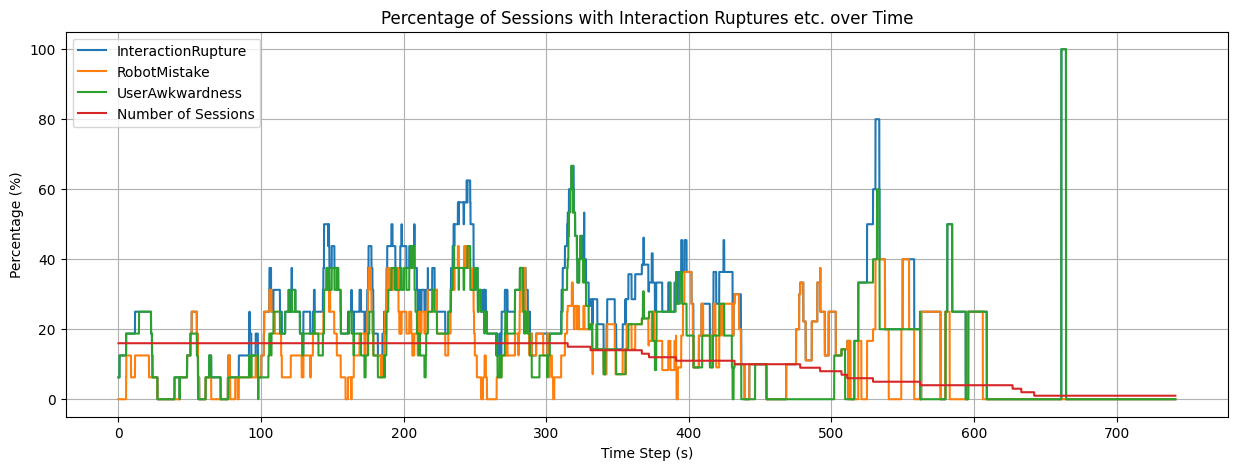

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# I'll assume 'data_hri' is already loaded and properly formatted.
# You should have the following:
# data_hri.val_Y -- a DataFrame with at least columns 'session' and 'InteractionRupture'.

# First, let's create a DataFrame to hold the percentage of InteractionRupture==1 per time step.
# This assumes that there's a 'time' or similar column in your DataFrame to group by.

# Extract unique session IDs and time steps
unique_sessions = data_hri.val_Y['session'].unique()
unique_time_steps = sorted(data_hri.val_Y['frame'].unique())  # Assuming a 'time' column exists

# Initialize an array to hold the percentage of InteractionRupture == 1 per time step
rupture_percentages = []
rupture_percentages_robot = []
rupture_percentages_user = []
number_of_sessions = []

# Calculate the percentage for each time step
for time_step in unique_time_steps:
    # Get all entries for this time step
    time_step_data = data_hri.val_Y[data_hri.val_Y['frame'] == time_step]
    # Calculate the percentage of InteractionRupture == 1
    percentage = 100 * (time_step_data['InteractionRupture'] == 1).mean()
    rupture_percentages.append(percentage)
    percentage_robot = 100 * (time_step_data['RobotMistake'] == 1).mean()
    rupture_percentages_robot.append(percentage_robot)
    percentage_user = 100 * (time_step_data['UserAwkwardness'] == 1).mean()
    rupture_percentages_user.append(percentage_user)
    number_of_sessions.append(len(time_step_data['session'].unique()))

# timestep to seconds
unique_time_steps = [x/100 for x in unique_time_steps]


# Plotting
plt.figure(figsize=(15, 5))
plt.plot(unique_time_steps, rupture_percentages, label='InteractionRupture')
plt.plot(unique_time_steps, rupture_percentages_robot, label='RobotMistake')
plt.plot(unique_time_steps, rupture_percentages_user, label='UserAwkwardness')
plt.plot(unique_time_steps, number_of_sessions, label='Number of Sessions')
plt.title('Percentage of Validation Sessions with Interaction Ruptures etc. over Time')
plt.xlabel('Time Step (s)')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.legend()
plt.show()

